<a href="https://colab.research.google.com/github/Timuringtorinx/AET/blob/main/Analysis_of_Extremist_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## loading the scripts

In [3]:
import re
import pandas as pd
import os

# 1. Understanding The Problem

**questions:**
-

# 2. Acquisition of Data

### 2.1 Acquire video

In [ ]:
%%bash
pip install openai-whisper
pip install pytube
apt install ffmpeg

# call the help method to validate installation and see the available commands and options
whisper --help

In [4]:
from pytube import YouTube

# Set the URL of the YouTube video
video_url = 'https://www.youtube.com/watch?v=6UtSi16wIh4'

# Create a YouTube object with the URL
yt = YouTube(video_url)

# Select the first stream available, usually the highest resolution
stream = yt.streams.first()

# Download the video to the current working directory in Colab
stream.download()

print("Download completed!")

Download completed!


### 2.2 Transcribe video (english)

### Step 3 - transcribe the video
The video is of an interview in German, so when we call Whisper it will perform its default `--task` which is transcribe.

We need to specify what model should Whisper use, please see [available models](https://github.com/openai/whisper#available-models-and-languages). These differ in size and resources need, at the time of writing they are `tiny`, `base`, `small`, `medium`, and `large`. `tiny` is the smallest, requires 1GB of ram and is 32 times faster than `large` which requires 10GB of ram. The results of `tiny` may not be good enough for your use cases, though. You can still find the sweet spot for your type of audio by testing smaller models first. For this video, the `small` model works well enough. `large` may literally be too large for some free Notebook environments.

The following command will transcribe using the small `--model`.

The first time you call Whisper with a new model, it will be downloaded to your environment so it will always take longer on the first attempt.

The duration of the transcription/translation depends on the model, on your system resources, and on the duration of the audio.

In [5]:
!whisper "/content/Lebanon in Crisis Palestinians and Lebanese in Resistance - Report of Ghassan Kanafani Brigade.mp4" --model large --language en

100%|██████████████████████████████████████| 2.88G/2.88G [00:22<00:00, 136MiB/s]
[00:00.000 --> 00:27.640]  Welcome to those of you who are joining this event.
[00:27.640 --> 00:36.180]  In order to give our participants time to sign on, we will just be waiting for a couple of minutes before we officially begin.
[00:36.840 --> 00:40.140]  And we're really excited to see you here today with us.
[00:57.640 --> 01:27.620]  Thank you.
[01:27.640 --> 01:52.280]  And hello again to those who are joining us.
[01:52.900 --> 01:57.400]  We are just waiting a few minutes for people to get on board and then we'll be getting
[01:57.400 --> 01:57.620]  started.
[01:57.640 --> 02:01.280]  And we're very excited to see you with us here today.
[02:01.400 --> 02:01.800]  Thank you.
[02:27.640 --> 02:57.620]  Thank you.
[02:57.640 --> 03:27.620]  Thank you.
[03:27.640 --> 03:57.620]  Thank you.
[03:57.640 --> 03:59.640]  Thank you.
[03:59.640 --> 04:01.640]  Thank you.
[04:01.640 --> 04:03.640]  Thank y

### 2.3 Transliterate video (whisper)

### Step 4 - translate the video

If the original audio is not English and you want it to be translated, you can specify the `--task` as `translate`.

If you don't instruct the tool to write to a specific format, it will create a result file for all available formats which include `.txt`, `.srt` (subtitle), `.json` and a few others. You can ask for a single one, such as text, with `--output_format txt` (see the help and documentation for more info).

In [ ]:
!whisper '/content/Video Mohammed Khatib speaks at the March for Return and Liberation.mp4' --model medium --task translate --output_format txt

# 3. Preparation of Data

clean url's

# 4. Analysis of Data

## Calculate proportion of extremist languange indicators

#### newest version

In [ ]:
import re
import pandas as pd
import os

# Define the paths to the manifestos
manifesto_files = ["/content/Tarrant Manifesto.txt"]  # Update the path accordingly

# Keywords for each category, including complex categories with sublists
categories = {
    "fusion": ["brotherhood", "sisterhood", "family", "our blood", "motherland", "fatherland",
               "kin", "my people", "my tribe", "ancestors", "descendants", "comrades",
               "unity", "collective", "inseparable", "our kind", "our lineage", "clan",
               "tribal", "united", "one people", "common destiny", "blood ties"],
    "violence": ["kill", "hang", "bomb", "shoot", "slaughter", "executed", "execution", "punish",
                 "death penalty", "massacre", "destroy", "must attack", "must fight", "revenge",
                 "retribution", "eradicate", "starve", "die", "torture", "behead", "burn",
                 "bring death to", "give them hell", "weapon", "firearm", "assassinate", "gun",
                 "rifle", "knife", "grenade", "brutal steps", "molotov", "jihaad", "jihad",
                 "set fire", "revolution", "forcible overthrow", "flamethrowers", "M1-16", "ammonium nitrate"],
    "slurs": ["kike", "nigger", "negro", "dirty jew", "spic", "fag", "goyim", "golem", "the jew", "global jewry", "pajeet", "bitch", "whore"],
    "demonisation": ["evil", "corrupt", "vicious", "deceitful", "barbaric", "enemies", "criminals",
                     "traitors", "aggressors", "infidels", "invaders", "snakes", "monsters", "fiends",
                     "heretics", "corruptors", "profaners", "betrayers", "deceivers", "saboteurs",
                     "desecrators", "plunderers", "traitor", "evil", "enemy", "corrupt", "vicious",
                     "barbaric", "depraved", "vile", "puppets", "perversion", "blood libel", "pervert",
                     "pedo", "crime", "cruel", "bloody", "genocidal", "sinful", "deceitful", "invader",
                     "poison", "parasite", "menace", "brutal", "ruthless", "bloodsucking", "dirty",
                     "deceptive", "treacherous", "poisonous", "oppressive", "oppressor", "shird",
                     "unbeliever", "immoral", "jahili", "pollute", "demolish", "shake the foundations",
                     "dar ul-harb", "arrogant", "mischievous", "criminal", "deceivers", "liars", "colonizers"],
    "dehumanisation": ["animal", "plague", "impure", "brute", "dog", "lower iq", "lower being",
                       "inferior", "squalid", "parasitic", "parasite", "creature", "trash", "filth",
                       "vermin", "spider", "devil", "monster", "beast", "reptile", "reptiloid", "femoid",
                       "reptilian", "snake", "cockroach", "beneath human skin", "sub human", "anti-human",
                       "disease", "savage", "infest", "breed", "locust", "monkey", "gorilla", "rat",
                       "microbe", "satan", "cancer", "scum", "pig"],
    "existential_threat": ["extermination", "genocide", "ethnic cleansing", "massacre", "annihilation", "destruction"],
    "conspiracy": ["new world order", "illuminati", "manipulation", "deep state", "shadow government", "secret societies"],
    "inevitable_war": [["war", "battle", "fight", "jihad", "collapse", "conflict"], ["imminent", "inevitable", "looming", "start", "begin", "already", "heading for", "ongoing", "stage", "phase", "when", "has been", "likely", "predict", "expect", "will happen", "has begun", "current", "impending"]],
    "existential_threat": ["extermination", "genocide", "ethnic cleansing", "massacre", "annihilation", "destruction"],
    "conspiracy": ["new world order", "illuminati", "manipulation", "deep state", "shadow government", "secret societies"],
    "inevitable_war": [["war", "battle", "fight", "jihad", "collapse", "conflict"], ["imminent", "inevitable", "looming", "start", "begin", "already", "heading for", "ongoing", "stage", "phase", "when", "has been", "likely", "predict", "expect", "will happen", "has begun", "current", "impending"]],
    "violence_justification": ["self-defense", "defensive killing", "just war", "preemptive strike", "necessary violence"],
    "martyrdom_narrative": ["martyr", "sacrifice", "heroic death", "eternal glory", "immortal cause"],
    "violent_role_model": [["freedom fighters", "liberation heroes", "warriors", "revolutionaries", "militants"], ["crusaders", "jihadists", "commanders", "war heroes", "patriotic icons"]],
    "identification": [["we", "us", "our"], ["they", "them", "their", "I", "me", "my", "you", "your"]],
    "hopelessness": [["democracy", "democratic", "peaceful", "political", "system", "politics", "dialogue", "passivity"], ["pointless negotiations", "failed diplomacy", "ineffective political solutions", "useless dialogue", "corrupt politicians", "rigged system", "no peace possible", "inevitable collapse", "dead end", "futile efforts", "betrayed", "meaningless efforts", "vain attempts", "hopeless causes", "deadlocked", "impotent measures", "inadequate", "pointless endeavors", "no hope left", "without remedy", "no alternatives"]]
}

# Function to extract sentences with category-specific keywords
def extract_sentences(text, keywords, is_complex=False):
    sentences = re.split(r'\.\s+', text)  # Split text into sentences
    matching_sentences = []
    if not is_complex:
        for sentence in sentences:
            if any(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, flags=re.IGNORECASE) for keyword in keywords):
                matching_sentences.append(sentence.strip())
    else:
        for sentence in sentences:
            if all(any(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, flags=re.IGNORECASE) for keyword in group) for group in keywords):
                matching_sentences.append(sentence.strip())
    return matching_sentences

# DataFrame to store results
results_df = pd.DataFrame(columns=['File', 'Category', 'Sentence'])

# Process each file
for file_path in manifesto_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read().lower()

    # Extract and store sentences for each category
    for category, keywords in categories.items():
        if isinstance(keywords[0], list):  # Check if the category uses complex keyword lists
            sentences = extract_sentences(text, keywords, is_complex=True)
        else:
            sentences = extract_sentences(text, keywords)
        for sentence in sentences:
            results_df = results_df.append({
                'File': os.path.basename(file_path),
                'Category': category,
                'Sentence': sentence
            }, ignore_index=True)

# Save results to CSV
results_df.to_csv('/content/Complete_Categorization_Results.csv', index=False)

# Print sample data
print(results_df.head())


#### New version

In [2]:
import re
import pandas as pd
import os

# Define the paths to the manifestos
manifesto_files = ["/content/Tarrant Manifesto.txt"]  # Update the path accordingly

# Keywords for each category
# Simple keyword lists
fusion_keywords = ["brotherhood", "sisterhood", "family", "our blood", "motherland", "fatherland",
                   "kin", "my people", "my tribe", "ancestors", "descendants", "comrades",
                   "unity", "collective", "inseparable", "our kind", "our lineage", "clan",
                   "tribal", "united", "one people", "common destiny", "blood ties"]

violence_keywords = ["kill", "hang", "bomb", "shoot", "slaughter", "executed", "execution", "punish",
                     "death penalty", "massacre", "destroy", "must attack", "must fight", "revenge",
                     "retribution", "eradicate", "starve", "die", "torture", "behead", "burn",
                     "bring death to", "give them hell", "weapon", "firearm", "assassinate", "gun",
                     "rifle", "knife", "grenade", "brutal steps", "molotov", "jihaad", "jihad",
                     "set fire", "revolution", "forcible overthrow", "flamethrowers", "M1-16", "ammonium nitrate"]

slurs_keywords = ["kike", "nigger", "negro", "dirty jew", "spic", "fag", "goyim", "golem", "the jew", "global jewry", "pajeet", "bitch", "whore"]

demonisation_keywords = ["evil", "corrupt", "vicious", "deceitful", "barbaric", "enemies", "criminals",
                         "traitors", "aggressors", "infidels", "invaders", "snakes", "monsters", "fiends",
                         "heretics", "corruptors", "profaners", "betrayers", "deceivers", "saboteurs",
                         "desecrators", "plunderers", "traitor", "evil", "enemy", "corrupt", "vicious",
                         "barbaric", "depraved", "vile", "puppets", "perversion", "blood libel", "pervert",
                         "pedo", "crime", "cruel", "bloody", "genocidal", "sinful", "deceitful", "invader",
                         "poison", "parasite", "menace", "brutal", "ruthless", "bloodsucking", "dirty",
                         "deceptive", "treacherous", "poisonous", "oppressive", "oppressor", "shird",
                         "unbeliever", "immoral", "jahili", "pollute", "demolish", "shake the foundations",
                         "dar ul-harb", "arrogant", "mischievous", "criminal", "deceivers", "liars", "colonizers"]

dehumanisation_keywords = ["animal", "plague", "impure", "brute", "dog", "lower iq", "lower being",
                           "inferior", "squalid", "parasitic", "parasite", "creature", "trash", "filth",
                           "vermin", "spider", "devil", "monster", "beast", "reptile", "reptiloid", "femoid",
                           "reptilian", "snake", "cockroach", "beneath human skin", "sub human", "anti-human",
                           "disease", "savage", "infest", "breed", "locust", "monkey", "gorilla", "rat",
                           "microbe", "satan", "cancer", "scum", "pig"]

existential_threat_keywords = ["subjected to", "coerced", "brainwashed", "exterminated", "brutalised", "raped", "terrorised", "ravaged", "extinction", "replacement", "genocide", "robbed", "subjugate", "make war upon my people", "destroy", "subvert", "overwhelmed", "under siege", "demographic siege", "disenfranchise", "assault", "kill us", "kill our", "kill my", "running out of time", "run out of time", "last chance", "enslavement", "enslaved", "suffer", "plunder", "condemned to death", "destruction of all mankind", "at the brink of", "endanger", "annihilation", "decay"]

conspiracy_belief_keywords = ["collusion", "secret plots", "undermining", "manipulation", "controlled media", "puppet masters", "hidden hands", "new world order", "globalists", "illuminati", "cultural marxism", "plotting", "scheming", "underminers", "subverters", "conspirators", "false flag operations", "shadow government", "deep state", "elite cabals", "manipulators"]

violence_justification_keywords = ["self-defense", "defense of the homeland", "protect our people", "retaliation", "necessary evil", "only option", "preemptive strike", "sacred duty", "moral obligation", "righteous violence", "act of valor", "act of war", "striking back", "counterattack", "just retaliation", "just cause", "defensive measure", "legitimate response", "moral duty", "for the greater good", "protective action"]


# Complex keyword lists (each sublist must have at least one keyword present)
identification = [["we", "us", "our"], ["they", "them", "their", "I", "me", "my", "you", "your"]]
violent_role_model = [["kanafani", "abdallah", "sa'adat"], ["crusaders", "freedom fighters", "liberation heroes",
                                                           "warriors", "legendary figures", "historical militants",
                                                           "iconic martyrs", "inspirational leaders", "revolutionaries",
                                                           "jihadists", "commanders", "war heroes", "patriotic icons",
                                                           "battle leaders", "vanguard", "spearheads", "pioneers",
                                                           "pathfinders", "trailblazers", "champions", "standard-bearers"]]
hopelessness = [["democracy", "democratic", "peaceful", "political", "system", "politics", "dialogue", "passivity"],
                ["pointless negotiations", "failed diplomacy", "ineffective political solutions", "useless dialogue",
                 "corrupt politicians", "rigged system", "no peace possible", "inevitable collapse", "dead end",
                 "futile efforts", "betrayed", "meaningless efforts", "vain attempts", "hopeless causes", "deadlocked",
                 "impotent measures", "inadequate", "pointless endeavors", "no hope left", "without remedy", "no alternatives"]]
inevitable_war = [["war", "battle", "fight", "jihad", "jihaad", "collapse", "conflict"],
                  ["imminent", "inevitable", "looming", "start", "begin", "already", "heading for", "ongoing",
                   "stage", "phase", "when", "has been", "likely", "predict", "expect", "will happen", "has begun",
                   "current", "impending"]]

# Define a DataFrame to store the results
results_df = pd.DataFrame(index=['fusion', 'violence', 'slurs', 'demonisation', 'dehumanisation',
                                 'identification', 'violent_role_model', 'hopelessness', 'inevitable_war'],
                          columns=[os.path.basename(f) for f in manifesto_files])

# Calculate the proportions of each category in a text
def calculate_proportions(text, keyword_groups, is_complex=False):
    sentences = re.split(r'\.\s+', text)
    total_sentences = len(sentences)
    if not is_complex:
        count = sum(any(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, re.IGNORECASE)
                        for keyword in keyword_groups) for sentence in sentences)
        return count / total_sentences * 100  # proportion in percentage
    else:
        count = 0
        for sentence in sentences:
            if all(any(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, re.IGNORECASE)
                       for keyword in group) for group in keyword_groups):
                count += 1
        return count / total_sentences * 100

# Read and analyze each manifesto
for file_path in manifesto_files:
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()

    # Calculate proportions for each category
    results_df.at['fusion', file_path] = calculate_proportions(text, fusion_keywords)
    results_df.at['violence', file_path] = calculate_proportions(text, violence_keywords)
    results_df.at['slurs', file_path] = calculate_proportions(text, slurs_keywords)
    results_df.at['demonisation', file_path] = calculate_proportions(text, demonisation_keywords)
    results_df.at['dehumanisation', file_path] = calculate_proportions(text, dehumanisation_keywords)
    results_df.at['conspiracy_belief', file_path] = calculate_proportions(text, conspiracy_belief_keywords)
    results_df.at['existential_threat', file_path] = calculate_proportions(text, existential_threat_keywords)
    results_df.at['violence_justification', file_path] = calculate_proportions(text, violence_justification_keywords)
    results_df.at['identification', file_path] = calculate_proportions(text, identification, is_complex=True)
    results_df.at['violent_role_model', file_path] = calculate_proportions(text, violent_role_model, is_complex=True)
    results_df.at['hopelessness', file_path] = calculate_proportions(text, hopelessness, is_complex=True)
    results_df.at['inevitable_war', file_path] = calculate_proportions(text, inevitable_war, is_complex=True)

# Save the results to a CSV file
results_df.to_csv("/content/Tarrant Manifesto_violentindicators.csv")


#### Old version

In [13]:

# Define the paths to the manifestos
manifesto_files = ["/content/Tarrant Manifesto.txt"] #insert text here

# Define your categories and keywords as provided in the appendix
# Example for 'fusion' category (repeat this pattern for other categories)
fusion_keywords = ["brotherhood", "sisterhood", "family", "our blood", "motherland", "fatherland",
                   "kin", "my people", "my tribe", "ancestors", "descendants", "comrades",
                   "unity", "collective", "inseparable", "our kind", "our lineage", "clan",
                   "tribal", "united", "one people", "common destiny", "blood ties"]
# (Add other keyword lists for different categories...)
#VIOLENCE
violence = ["kill","hang","bomb","shoot","slaughter","executed","execution","punish","death penalty","massacre","destroy","must attack","must fight","revenge","retribution","eradicate","starve","die","torture","behead","burn","bring death to","give them hell","weapon","firearm","assassinate","gun","rifle","knife","grenade","brutal steps","molotov","jihaad","jihad","set fire","revolution","forcible overthrow","flamethrowers","M1-16","ammonium nitrate"]
# Identification
identification1 = [r"\bwe\b", r"\bus\b", r"\bour\b", r"\bthey\b", r"\bthem\b", r"\btheir\b"]
identification2 = [r"\bI\b", r"\bme\b", r"\bmy\b", r"\byou\b", r"\byour\b"]

# Slurs
slurs = ["kike", "nigger", "negro", "dirty jew", "spic", "fag", "goyim", "golem", "the jew", "global jewry", "pajeet", "bitch", "whore"]

# Demonisation
demonisation = ["evil", "corrupt", "vicious", "deceitful", "barbaric", "enemies", "criminals", "traitors", "aggressors", "infidels", "invaders", "snakes", "monsters", "fiends", "heretics", "corruptors", "profaners", "betrayers", "deceivers", "saboteurs", "desecrators", "plunderers", "traitor", "evil", "enemy", "corrupt", "vicious", "barbaric", "depraved", "vile", "puppets", "perversion", "blood libel", "pervert", "pedo", "crime", "cruel", "bloody", "genocidal", "sinful", "deceitful", "invader", "poison", "parasite", "menace", "brutal", "ruthless", "bloodsucking", "dirty", "deceptive", "treacherous", "poisonous", "oppressive", "oppressor", "shird", "unbeliever", "immoral", "jahili", "pollute", "demolish", "shake the foundations", "dar ul-harb", "arrogant", "mischievous", "criminal", "deceivers", "liars", "colonizers"]

# Dehumanisation
dehumanisation = ["animal", "plague", "impure", "brute", "dog", "lower iq", "lower being", "inferior", "squalid", "parasitic", "parasite", "creature", "trash", "filth", "vermin", "spider", "devil", "monster", "beast", "reptile", "reptiloid", "femoid", "reptilian", "snake", "cockroach", "beneath human skin", "sub human", "anti-human", "disease", "savage", "infest", "breed", "locust", "monkey", "gorilla", "rat", "microbe", "satan", "cancer", "scum", "pig"]

# Existential Threat
existential_threat = ["subjected to", "coerced", "brainwashed", "exterminated", "brutalised", "raped", "terrorised", "ravaged", "extinction", "replacement", "genocide", "robbed", "subjugate", "make war upon my people", "destroy", "subvert", "overwhelmed", "under siege", "demographic siege", "disenfranchise", "assault", "kill us", "kill our", "kill my", "running out of time", "run out of time", "last chance", "enslavement", "enslaved", "suffer", "plunder", "condemned to death", "destruction of all mankind", "at the brink of", "endanger", "annihilation", "decay"]

# Belief in Conspiracy
conspiracy_belief = ["collusion", "secret plots", "undermining", "manipulation", "controlled media", "puppet masters", "hidden hands", "new world order", "globalists", "illuminati", "cultural marxism", "plotting", "scheming", "underminers", "subverters", "conspirators", "false flag operations", "shadow government", "deep state", "elite cabals", "manipulators"]

# Belief in Inevitable War
inevitable_war1 = ["war", "battle", "fight", "jihad", "jihaad", "collapse", "conflict"]
inevitable_war2 = ["imminent", "inevitable", "looming", "start", "begin", "already", "heading for", "ongoing", "stage", "phase", "when", "has been", "likely", "predict", "expect", "will happen", "has begun", "current", "impending"]

# Violence Justification
violence_justification = ["self-defense", "defense of the homeland", "protect our people", "retaliation", "necessary evil", "only option", "preemptive strike", "sacred duty", "moral obligation", "righteous violence", "act of valor", "act of war", "striking back", "counterattack", "just retaliation", "just cause", "defensive measure", "legitimate response", "moral duty", "for the greater good", "protective action"]

# Martyrdom Narrative
martyrdom_narrative = ["sacrifice", "martyr", "heroic death", "eternal glory", "immortal cause", "die for the cause", "ultimate sacrifice", "for the future", "for the children", "defense of faith", "holy martyr", "lay down one’s life", "fall for the cause", "ultimate offering", "heroic sacrifice", "glorious death", "fight to the death", "sacrificial lamb", "die a hero", "give one’s life", "blood offering"]

# Violent Role Model
violent_role_model1 = ["kanafani", "abdallah", "saadat"]
violent_role_model2 = ["crusaders", "freedom fighters", "liberation heroes", "warriors", "legendary figures", "historical militants", "iconic martyrs", "inspirational leaders", "revolutionaries", "jihadists", "commanders", "war heroes", "patriotic icons", "battle leaders", "vanguard", "spearheads", "pioneers", "pathfinders", "trailblazers", "champions", "standard-bearers"]

# Hopelessness of Alternative Solutions
hopelessness_of_alternatives1 = ["democracy", "democratic", "peaceful", "political", "system", "politics", "dialogue", "passivity"]
hopelessness_of_alternatives2 = ["pointless negotiations", "failed diplomacy", "ineffective political solutions", "useless dialogue", "corrupt politicians", "rigged system", "no peace possible", "inevitable collapse", "dead end", "futile efforts", "betrayed", "meaningless efforts", "vain attempts", "hopeless causes", "deadlocked", "impotent measures", "inadequate", "pointless endeavors", "no hope left", "without remedy", "no alternatives"]


# Initialize a DataFrame to store the results
results_df = pd.DataFrame(index=['fusion', 'violence', 'slurs', 'demonisation', 'dehumanisation',
                                 'existential_threat', 'conspiracy', 'violence_justification',
                                 'martyr', 'violent_role_model', 'identification1', 'identification2', 'hopelessness',
                                 'inevitable_war', 'total_sentences', 'mean_tokens_per_sentence'],
                         columns=[os.path.basename(f) for f in manifesto_files])



# Function to calculate the proportions of each category in a text
def calculate_proportions(text, keywords):
    sentences = re.split(r'\.\s+', text)
    proportions = {}
    for keyword in keywords:
        count = sum(bool(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, re.IGNORECASE))
                    for sentence in sentences)
        proportions[keyword] = count / len(sentences) * 100  # proportion in percentage
    return proportions

# Read and analyze each manifesto
for file_path in manifesto_files:
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()

    # Calculate proportions for each category and add to DataFrame
    for category_name, keyword_list in [('fusion', fusion_keywords), ('violence', violence), ('slurs', slurs), ('demonisation', demonisation), ('dehumanisation', dehumanisation), ('existential_threat', existential_threat), ('conspiracy', conspiracy_belief), ('violence_justification', violence_justification), ('martyr', martyrdom_narrative), ('violent_role_model', violent_role_model2), ('identification1', identification1), ('identification2', identification2), ('hopelesness', hopelessness_of_alternatives2), ('inevitable_war', inevitable_war2)
                                        ]:
        category_proportions = calculate_proportions(text, keyword_list)
        results_df.at[category_name, file_path] = sum(category_proportions.values())

    # Add sentence count and mean tokens per sentence
    sentences = re.split(r'\.\s+', text)
    results_df.at['total_sentences', file_path] = len(sentences)
    results_df.at['mean_tokens_per_sentence', file_path] = \
        pd.Series([len(re.findall(r'\w+', sentence)) for sentence in sentences]).mean()

# Output the DataFrame to a CSV file
results_df.to_csv("/content/Tarrant Manifest_validation.csv")

direction of violence

In [ ]:
def extract_violence_context(text):
    sentences = re.split(r'\.\s+', text)
    violence_keywords = ["kill", "hang", "bomb", "shoot", "slaughter", "executed", "execution", "punish",
                         "death penalty", "massacre", "destroy", "must attack", "must fight", "revenge",
                         "retribution", "eradicate", "starve", "die", "torture", "behead", "burn"]
    identification_us = ["we", "us", "our"]
    identification_them = ["they", "them", "their"]
    matching_sentences = []

    for sentence in sentences:
        contains_violence = any(re.search(r'\b' + re.escape(violence_keyword) + r'\b', sentence, flags=re.IGNORECASE) for violence_keyword in violence_keywords)
        directed_at_us = any(re.search(r'\b' + re.escape(id_us) + r'\b', sentence, flags=re.IGNORECASE) for id_us in identification_us)
        directed_at_them = any(re.search(r'\b' + re.escape(id_them) + r'\b', sentence, flags=re.IGNORECASE) for id_them in identification_them)

        if contains_violence:
            if directed_at_us and directed_at_them:
                context = "both"
            elif directed_at_us:
                context = "us"
            elif directed_at_them:
                context = "them"
            else:
                context = "unknown"

            matching_sentences.append((sentence.strip(), context))

    return matching_sentences


## Validate Proportions of extremist language indicators
(manual review)

#### New validation method

In [3]:
import re
import pandas as pd
import os

# Define the paths to the manifestos
manifesto_files = ["/content/Tarrant Manifesto.txt"]  # Update the path to the actual manifesto file

# Categories and Keywords
categories = {
    "fusion": ["brotherhood", "sisterhood", "family", "our blood", "motherland", "fatherland",
               "kin", "my people", "my tribe", "ancestors", "descendants", "comrades",
               "unity", "collective", "inseparable", "our kind", "our lineage", "clan",
               "tribal", "united", "one people", "common destiny", "blood ties"],
    "violence": ["kill", "hang", "bomb", "shoot", "slaughter", "executed", "execution", "punish",
                 "death penalty", "massacre", "destroy", "must attack", "must fight", "revenge",
                 "retribution", "eradicate", "starve", "die", "torture", "behead", "burn",
                 "bring death to", "give them hell", "weapon", "firearm", "assassinate", "gun",
                 "rifle", "knife", "grenade", "brutal steps", "molotov", "jihaad", "jihad",
                 "set fire", "revolution", "forcible overthrow", "flamethrowers", "M1-16", "ammonium nitrate"],
    "slurs": ["kike", "nigger", "negro", "dirty jew", "spic", "fag", "goyim", "golem", "the jew", "global jewry", "pajeet", "bitch", "whore"],
    "demonisation": ["evil", "corrupt", "vicious", "deceitful", "barbaric", "enemies", "criminals",
                     "traitors", "aggressors", "infidels", "invaders", "snakes", "monsters", "fiends",
                     "heretics", "corruptors", "profaners", "betrayers", "deceivers", "saboteurs",
                     "desecrators", "plunderers", "traitor", "evil", "enemy", "corrupt", "vicious",
                     "barbaric", "depraved", "vile", "puppets", "perversion", "blood libel", "pervert",
                     "pedo", "crime", "cruel", "bloody", "genocidal", "sinful", "deceitful", "invader",
                     "poison", "parasite", "menace", "brutal", "ruthless", "bloodsucking", "dirty",
                     "deceptive", "treacherous", "poisonous", "oppressive", "oppressor", "shird",
                     "unbeliever", "immoral", "jahili", "pollute", "demolish", "shake the foundations",
                     "dar ul-harb", "arrogant", "mischievous", "criminal", "deceivers", "liars", "colonizers"],
    "dehumanisation": ["animal", "plague", "impure", "brute", "dog", "lower iq", "lower being",
                       "inferior", "squalid", "parasitic", "parasite", "creature", "trash", "filth",
                       "vermin", "spider", "devil", "monster", "beast", "reptile", "reptiloid", "femoid",
                       "reptilian", "snake", "cockroach", "beneath human skin", "sub human", "anti-human",
                       "disease", "savage", "infest", "breed", "locust", "monkey", "gorilla", "rat",
                       "microbe", "satan", "cancer", "scum", "pig"],
    "existential_threat": ["subjected to", "coerced", "brainwashed", "exterminated", "brutalised", "raped", "terrorised", "ravaged", "extinction", "replacement", "genocide", "robbed", "subjugate", "make war upon my people", "destroy", "subvert", "overwhelmed", "under siege", "demographic siege", "disenfranchise", "assault", "kill us", "kill our", "kill my", "running out of time", "run out of time", "last chance", "enslavement", "enslaved", "suffer", "plunder", "condemned to death", "destruction of all mankind", "at the brink of", "endanger", "annihilation", "decay"],
    "conspiracy": ["collusion", "secret plots", "undermining", "manipulation", "controlled media", "puppet masters", "hidden hands", "new world order", "globalists", "illuminati", "cultural marxism", "plotting", "scheming", "underminers", "subverters", "conspirators", "false flag operations", "shadow government", "deep state", "elite cabals", "manipulators"],
    "inevitable_war": ["war", "battle", "fight", "jihad", "jihaad", "collapse", "conflict", "imminent", "inevitable", "looming", "start", "begin", "already", "heading for", "ongoing", "stage", "phase", "when", "has been", "likely", "predict", "expect", "will happen", "has begun", "current", "impending"],
    "violence_justification": ["self-defense", "defense of the homeland", "protect our people", "retaliation", "necessary evil", "only option", "preemptive strike", "sacred duty", "moral obligation", "righteous violence", "act of valor", "act of war", "striking back", "counterattack", "just retaliation", "just cause", "defensive measure", "legitimate response", "moral duty", "for the greater good", "protective action"]
}

# Function to detect and extract sentences for each category
def extract_category_sentences(text, keywords):
    sentences = re.split(r'\.\s+', text)  # Split text into sentences
    category_sentences = []
    for sentence in sentences:
        if any(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, flags=re.IGNORECASE) for keyword in keywords):
            category_sentences.append(sentence.strip())
    return category_sentences

# DataFrame to store results
results_df = pd.DataFrame()

# Read and analyze each manifesto
for file_path in manifesto_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read().lower()

    # Extract sentences for each category and append to DataFrame
    for category_name, keywords in categories.items():
        extracted_sentences = extract_category_sentences(text, keywords)
        new_rows = pd.DataFrame({
            'File': os.path.basename(file_path),
            'Category': category_name,
            'Sentence': extracted_sentences
        })
        results_df = pd.concat([results_df, new_rows], ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('/content/Tarrant Manifesto_ManualReview.csv', index=False)  # Update the path to where you want to save the CSV

# Optionally, print the DataFrame to the console
print(results_df)


                      File                Category  \
0    Tarrant Manifesto.txt                  fusion   
1    Tarrant Manifesto.txt                  fusion   
2    Tarrant Manifesto.txt                  fusion   
3    Tarrant Manifesto.txt                  fusion   
4    Tarrant Manifesto.txt                  fusion   
..                     ...                     ...   
347  Tarrant Manifesto.txt          inevitable_war   
348  Tarrant Manifesto.txt          inevitable_war   
349  Tarrant Manifesto.txt          inevitable_war   
350  Tarrant Manifesto.txt  violence_justification   
351  Tarrant Manifesto.txt  violence_justification   

                                              Sentence  
0    but it is\nno simple task.there are myriad rea...  
1    born in australia to a working\nclass,low inco...  
2    i am just a regular white man, from a regular ...  
3    who decided to take a stand to ensure a future...  
4    to agitate the political enemies of my people ...  
..       

#### Identification test

In [4]:
import re
import pandas as pd

# Specify the path to your text file
file_path = "/content/Tarrant Manifesto.txt"  # Adjust this path as needed
process_text_file(file_path)

def extract_violence_context(text):
    # Split the text into sentences
    sentences = re.split(r'\.\s+', text)
    # Define keywords related to violence
    violence_keywords = ["kill", "hang", "bomb", "shoot", "slaughter", "executed", "execution", "punish",
                         "death penalty", "massacre", "destroy", "must attack", "must fight", "revenge",
                         "retribution", "eradicate", "starve", "die", "torture", "behead", "burn"]
    # Define identifiers for "us" and "them"
    identification_us = ["we", "us", "our"]
    identification_them = ["they", "them", "their"]

    results = []
    # Analyze each sentence
    for sentence in sentences:
        contains_violence = any(re.search(r'\b' + re.escape(keyword) + r'\b', sentence, flags=re.IGNORECASE) for keyword in violence_keywords)
        directed_at_us = any(re.search(r'\b' + re.escape(id_us) + r'\b', sentence, flags=re.IGNORECASE) for id_us in identification_us)
        directed_at_them = any(re.search(r'\b' + re.escape(id_them) + r'\b', sentence, flags=re.IGNORECASE) for id_them in identification_them)

        if contains_violence:
            if directed_at_us and directed_at_them:
                context = "both"
            elif directed_at_us:
                context = "us"
            elif directed_at_them:
                context = "them"
            else:
                context = "unknown"
            results.append({"Sentence": sentence.strip(), "Context": context})

    return results

def process_text_file(filepath):
    # Read the file
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read().lower()

    # Extract sentences with violence context
    violence_contexts = extract_violence_context(text)

    # Convert to DataFrame
    df = pd.DataFrame(violence_contexts)

    # Save to CSV
    df.to_csv(filepath + "_violence_contexts.csv", index=False)
    print(f"Results saved to {filepath}_violence_contexts.csv")

# Specify the path to your text file
file_path = "/content/Tarrant Manifesto_ViolenceDirection.csv"  # Replace this with the actual path to your text file
process_text_file(file_path)


NameError: name 'process_text_file' is not defined

## Measure toxicity of sentences (detoxify)

In [2]:
pip install detoxify

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import os
from detoxify import Detoxify
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import csv
from tqdm import tqdm

# Directory where your text files are stored
directory = '/content/drive/MyDrive/Projecten/Samidoun_Final/Youtube Data/Report of Ghassan Kanafani'

# Initialize the Detoxify model
model = Detoxify('original')

# CSV file to store the results
csv_file_path = '/content/drive/MyDrive/Projecten/Samidoun_Final/Results Data/Report of Ghassan Kanafani Brigade_toxicity.csv'

# Column headers for the CSV file
headers = ['Source File', 'Sentence', 'Toxicity', 'Severe Toxicity', 'Obscene', 'Threat', 'Insult', 'Identity Attack']

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(headers)  # Write the column headers

    # Get a list of all text files in the directory
    text_files = [f for f in os.listdir(directory) if f.endswith(".txt")]

    # Iterate over each file in the directory with a progress bar
    for filename in tqdm(text_files, desc="Processing files"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()  # Read the content of the file
            sentences = sent_tokenize(text)  # Tokenize the text into sentences

            # Evaluate each sentence using Detoxify and write the results to the CSV
            for sentence in tqdm(sentences, desc=f"Analyzing {filename}", leave=False):
                results = model.predict(sentence)
                row = [
                    filename,  # Source file
                    sentence,  # Sentence text
                    results['toxicity'],  # Toxicity score
                    results['severe_toxicity'],  # Severe toxicity score
                    results['obscene'],  # Obscene score
                    results['threat'],  # Threat score
                    results['insult'],  # Insult score
                    results['identity_attack']  # Identity attack score
                ]
                csvwriter.writerow(row)  # Write the row to the CSV file


## Analyse extremist SVO triplets

# 5. Conveyence of Message

In [12]:
import matplotlib.pyplot as plt

# Count the number of sentences per category
category_counts = results_df['Category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Sentences per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


KeyError: 'Category'

In [10]:
from wordcloud import WordCloud

# Generate a word cloud for a specific category
def generate_word_cloud(category):
    text = ' '.join(results_df[results_df['Category'] == category]['Sentence'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

# Example: Generate word cloud for the 'violence' category
generate_word_cloud('violence')
generate_word_cloud('slurs')
generate_word_cloud('demonisation')
generate_word_cloud('dehumanisation')
generate_word_cloud('identification')
generate_word_cloud('violent_role_model')
generate_word_cloud('hopelessness')
generate_word_cloud('inevitable_war')


KeyError: 'Category'

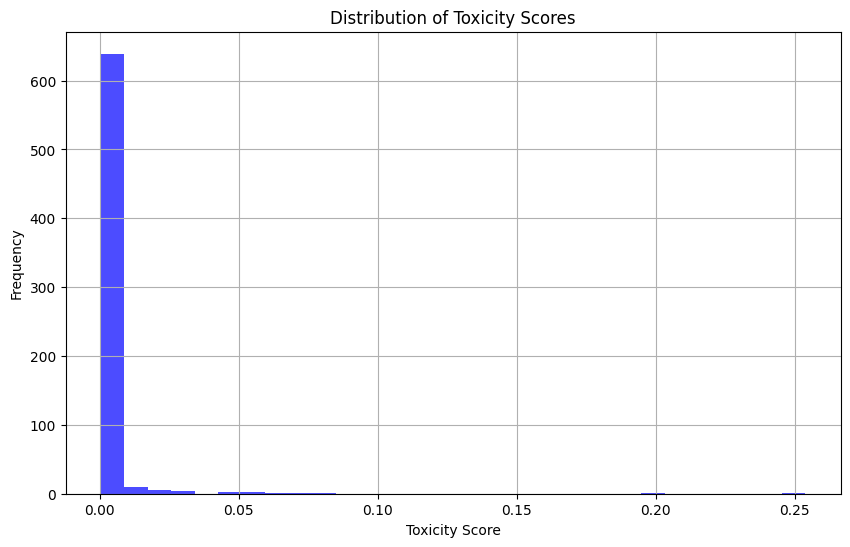

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your results CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Projecten/Samidoun_Final/Results Data/Report of Ghassan Kanafani Brigade_toxicity.csv')

# Plotting a histogram for the 'Toxicity' column
plt.figure(figsize=(10, 6))
plt.hist(df['Toxicity'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Toxicity Scores')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
